# Dynamics of scalar-modulated system

Dynamics equation:

$\dot{x}(x, t) = u(t)w(x) + v_0(x); \;\; x(0) = 0$

## Candidate recipe for stabilizing through scalar modulation:

Choose $u(t)$ fluctuating approx on timescale of expected timing errors to correct.

Pick any $w(x^*(t))$ same sign as $du/dt(t)$ for all $t$.

Pick $v_0(x^*(t))$ s.t. $\dot{x}^*(t) = u(t)w(x^*(t)) + v_0(x^*(t))$ for all $t$.

In [1]:
%matplotlib inline
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter1d as smooth
import sys

from aux import Generic, get_idx
from disp import set_font_size

# Example

In [2]:
DT = .001
DX = .001

Sinusoidal modulation:

$x^*(t) = t$

$u(t) = 1 + cos(t)$

$w(x) = -sin(x)$

$v_0(x) = [1 + sin(x)]cos(x)$

General solution:

Let $x^*(t) = t$.

Choose $u(t)$ that fluctuates in time around 1.

$w(x) = W\frac{du(t)}{dt}\big \rvert_{t=x} \quad \quad W > 0$

$v_0(x) = 1-w(x)u(t)|_{t=x}$

..................................................

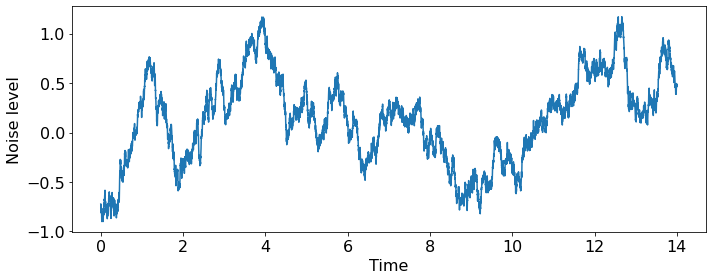

In [3]:
T_MAX = 16
X_MAX = 16

T_STOP = 14

TAU_ETA = 1
SGM = .6/np.sqrt(DT)

N_TR = 50

# fixed structures
t_smln = np.arange(0, T_STOP, DT)

## noise process
t_eta = np.arange(-5*TAU_ETA, T_STOP+5*TAU_ETA, DT)
mt_eta = (0 <= t_eta) & (t_eta < T_STOP)

## speed landscape
t = np.arange(0, T_MAX, DT)
x = np.arange(0, X_MAX, DX)

u_arr = 1 + np.cos(t)
w_arr = -.75*np.sin(x)
v0_arr = 1 - u_arr*w_arr

## funcs for getting nearest value

def u(t_samp):
    return u_arr[get_idx(t_samp, 0, DT, len(t))]

def w(x_samp):
    return w_arr[get_idx(x_samp, 0, DX, len(x))]

def v0(x_samp):
    return v0_arr[get_idx(x_samp, 0, DX, len(x))]

t2v = w_arr[:, None] @ u_arr[None, :] + np.tile(v0_arr[:, None], (1, len(t)))
v_diff_u = t2v.max() - 1
v_diff_l = 1 - t2v.min()

if v_diff_u > v_diff_l:
    v_min = 1 - v_diff_u
    v_max = 1 + v_diff_u
else:
    v_min = 1 - v_diff_l
    v_max = 1 + v_diff_l

# trial loop
np.random.seed(None)
x_trs = []  # trials
x_trs_ctl = []  # control trials with no speed correction

for ctr in range(N_TR):
    sys.stdout.write('.')
    # sample O-U noise
    eta = np.nan * np.zeros(len(t_eta))
    eta[0] = 0

    for ct, t_ in enumerate(t_eta[1:], 1):
        eta[ct] = eta[ct-1] + (DT/TAU_ETA) * (-eta[ct-1] + SGM*np.random.randn())

    eta = eta[mt_eta]

    if ctr == 0:  # plot example noise to make sure looks okay
        fig, ax = plt.subplots(1, 1, figsize=(10, 4), tight_layout=True)
        ax.plot(t_smln, eta)
        ax.set_xlabel('Time')
        ax.set_ylabel('Noise level')
        set_font_size(ax, 16)

    # main simulation loop
    x_tr = np.nan * np.zeros(len(t_smln))
    x_tr_ctl = np.nan * np.zeros(len(t_smln))

    x_tr[0] = 0
    x_tr_ctl[0] = 0

    for ct, _t in enumerate(t_smln[1:], 1):
        
        # speed-corrected trial
        _x = x_tr[ct-1]

        _v = u(_t)[0]*w(_x)[0] + v0(_x)[0] + eta[ct]
        _v = np.clip(_v, 0, 2)  # no negative velocities, and max is twice true velocity
        x_tr[ct] = _x + _v*DT

        # matched non-speed-corrected control trial
        _x = x_tr_ctl[ct-1]

        _v = 1 + eta[ct]
        _v = np.clip(_v, 0, 2)  # no negative velocities, and max is twice true velocity
        x_tr_ctl[ct] = _x + _v*DT

    x_trs.append(x_tr.copy())
    x_trs_ctl.append(x_tr_ctl.copy())
    
x_trs = np.array(x_trs)
x_trs_ctl = np.array(x_trs_ctl)

Min: 0.026, Max: 1.974, Std: 0.458


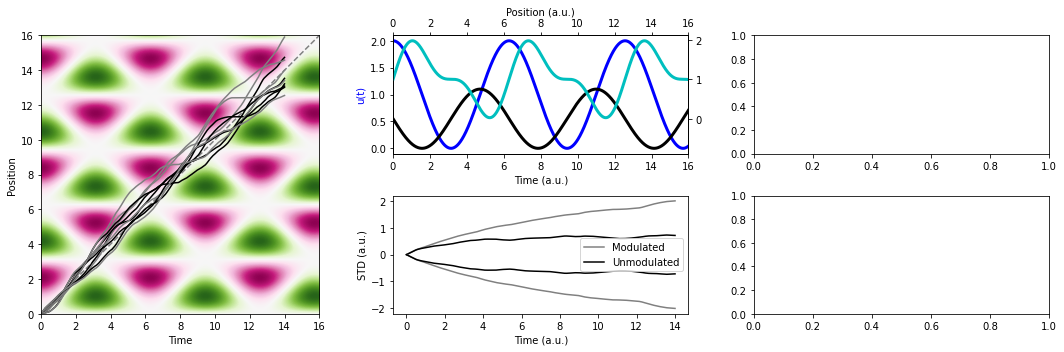

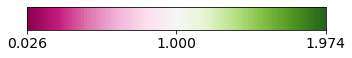

In [4]:
N_TR_SHOW = 5

fig = plt.figure(figsize=(15, 5), tight_layout=True)
gs = gridspec.GridSpec(2, 3)
axs = [
    fig.add_subplot(gs[:, 0]),  # speed landscape & example trajectories
    fig.add_subplot(gs[0, 1]),  # modulation time course
    None,                       # modulation spatial profile (shared w/ previous axis)
    fig.add_subplot(gs[1, 1]),  # trajectories STD over time
    fig.add_subplot(gs[0, 2]),  # real birdsong spectrogram
    fig.add_subplot(gs[1, 2]),  # amplitude and peak/duration defintions from real birdsong
]

# speed landscape and trajectories
axs[0].imshow(t2v, origin='lower', cmap='PiYG', vmin=v_min, vmax=v_max, extent=[0, T_MAX, 0, X_MAX])

axs[0].plot([0, T_MAX], [0, T_MAX], c='gray', ls='--')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Position')
print('Min: {0:.3f}, Max: {1:.3f}, Std: {2:.3f}'.format(v_min, v_max, t2v.std()))

for x_tr, x_tr_ctl in zip(x_trs[:N_TR_SHOW], x_trs_ctl[:N_TR_SHOW]):
    
    axs[0].plot(t_smln, x_tr, c='k')
    axs[0].plot(t_smln, x_tr_ctl, c='gray')

axs[0].set_xlim(0, T_MAX)
axs[0].set_ylim(0, X_MAX)

# modulation time course
axs[1].plot(t, u(t), c='b', lw=3)
axs[1].set_xlim(0, T_MAX)

axs[1].set_xlabel('Time (a.u.)')
axs[1].set_ylabel('u(t)', color='b')

# modulation spatial profile
ax1_twin = axs[1].twinx().twiny()
ax1_twin.plot(x, w(x), c='k', lw=3)
ax1_twin.plot(x, v0(x), c='c', lw=3)
ax1_twin.set_xlim(0, X_MAX)
ax1_twin.set_xlabel('Position (a.u.)')
ax1_twin.set_ylabel('w(x), $v_0$(x)')

axs[2] = ax1_twin

axs[3].plot(t_smln, x_trs_ctl.std(0), c='gray')
axs[3].plot(t_smln, x_trs.std(0), c='k')
axs[3].plot(t_smln, -x_trs_ctl.std(0), c='gray')
axs[3].plot(t_smln, -x_trs.std(0), c='k')

axs[3].set_xlabel('Time (a.u.)')
axs[3].set_ylabel('STD (a.u.)')
axs[3].legend(['Modulated', 'Unmodulated'])

# colorbar
fig, ax = plt.subplots(1, 1, figsize=(5, 1), tight_layout=True)
ax.matshow(np.linspace(v_min, v_max, 100)[None, :], origin='lower', vmin=v_min, vmax=v_max, cmap='PiYG',
           extent=[v_min, v_max, 0, .15])
ax.set_xticks([v_min, 1, v_max])
ax.xaxis.tick_bottom()
ax.yaxis.set_visible(False)

set_font_size(ax, 14)

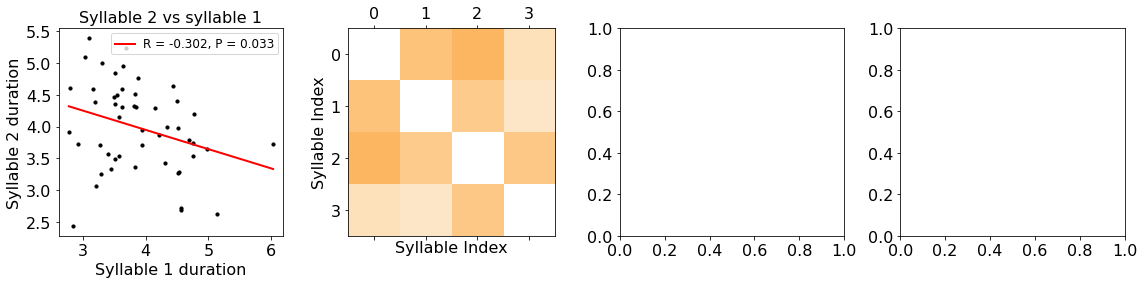

In [5]:
from itertools import product as cprod
from scipy import stats

# analyze "syllable" durations
x_bds = [0, 3, 7, 11, 14]
t_bds = np.nan*np.zeros((N_TR, len(x_bds)))
t_bds[:, 0] = 0

t_bds_ctl = np.nan*np.zeros((N_TR, len(x_bds)))
t_bds_ctl[:, 0] = 0

for cx_tr, (x_tr, x_tr_ctl) in enumerate(zip(x_trs, x_trs_ctl)):
    for cx_bd, x_bd in enumerate(x_bds[1:], 1):
        # modulated trial
        if x_bd <= x_tr[-1]:
            t_bd = DT*np.nonzero(x_bd < x_tr)[0][0]
        else:
            t_bd = np.nan
        t_bds[cx_tr, cx_bd] = t_bd
        
        # unmodulated trial
        if x_bd <= x_tr_ctl[-1]:
            t_bd_ctl = DT*np.nonzero(x_bd < x_tr_ctl)[0][0]
        else:
            t_bd_ctl = np.nan
        t_bds_ctl[cx_tr, cx_bd] = t_bd_ctl

syl_durs = np.diff(t_bds, axis=1)
syl_durs_ctl = np.diff(t_bds_ctl, axis=1)

n_syl = syl_durs.shape[1]

# calc lin fits and slopes for all pairs of syllable durations
slps = np.nan * np.zeros((n_syl, n_syl))
icpts = np.nan * np.zeros((n_syl, n_syl))
rs = np.nan * np.zeros((n_syl, n_syl))
ps = np.nan * np.zeros((n_syl, n_syl))


slps_ctl = np.nan * np.zeros((n_syl, n_syl))
icpts_ctl = np.nan * np.zeros((n_syl, n_syl))
rs_ctl = np.nan * np.zeros((n_syl, n_syl))
ps_ctl = np.nan * np.zeros((n_syl, n_syl))


for csyl_0, csyl_1 in cprod(range(n_syl), range(n_syl)):
    # modulated trials
    durs_0 = syl_durs[:, csyl_0]
    durs_1 = syl_durs[:, csyl_1]
    
    mvalid = (~np.isnan(durs_0)) & (~np.isnan(durs_1))
    slp, icpt, r, p, _ = stats.linregress(durs_0[mvalid], durs_1[mvalid])
    slps[csyl_0, csyl_1] = slp
    icpts[csyl_0, csyl_1] = icpt
    rs[csyl_0, csyl_1] = r
    ps[csyl_0, csyl_1] = p

    # unmodulated control trials
    durs_0_ctl = syl_durs_ctl[:, csyl_0]
    durs_1_ctl = syl_durs_ctl[:, csyl_1]
    
    mvalid_ctl = (~np.isnan(durs_0_ctl)) & (~np.isnan(durs_1_ctl))
    slp_ctl, icpt_ctl, r_ctl, p_ctl, _ = stats.linregress(durs_0_ctl[mvalid_ctl], durs_1_ctl[mvalid_ctl])
    slps_ctl[csyl_0, csyl_1] = slp_ctl
    icpts_ctl[csyl_0, csyl_1] = icpt_ctl
    rs_ctl[csyl_0, csyl_1] = r_ctl
    ps_ctl[csyl_0, csyl_1] = p_ctl
    
rs[np.eye(n_syl, dtype=bool)] = np.nan
rs_ctl[np.eye(n_syl, dtype=bool)] = np.nan

SHOW_IDXS = (1, 2)  # which syllable durations to make example plots for
syl_durs_0 = syl_durs[:, SHOW_IDXS[0]]
syl_durs_1 = syl_durs[:, SHOW_IDXS[1]]
slp = slps[SHOW_IDXS[0], SHOW_IDXS[1]]
icpt = icpts[SHOW_IDXS[0], SHOW_IDXS[1]]
r = rs[SHOW_IDXS[0], SHOW_IDXS[1]]
p = ps[SHOW_IDXS[0], SHOW_IDXS[1]]

fig, axs = plt.subplots(1, 4, figsize=(16, 4), tight_layout=True)
xs_line = np.array([np.nanmin(syl_durs_0), np.nanmax(syl_durs_0)])
ys_line = slp*xs_line + icpt

axs[0].plot(xs_line, ys_line, c='r', lw=2)

axs[0].scatter(syl_durs_0, syl_durs_1, s=10, c='k')
axs[0].set_xlabel('Syllable 1 duration')
axs[0].set_ylabel('Syllable 2 duration')
axs[0].set_title(f'Syllable {SHOW_IDXS[1]} vs syllable {SHOW_IDXS[0]}')

axs[0].legend([f'R = {r:.3f}, P = {p:.3f}'])

axs[1].matshow(rs, vmin=-1, vmax=1, cmap='PuOr')
axs[1].set_xlabel('Syllable Index')
axs[1].set_ylabel('Syllable Index')

set_font_size(axs, 16, legend_font_size=12)